In [9]:
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow import keras

In [10]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [11]:
def UNet():
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

In [12]:
model = UNet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_1 (Lambda)              (None, 128, 128, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 128, 128, 16  448         ['lambda_1[0][0]']               
                                )                                                                 
                                                                                            

 conv2d_34 (Conv2D)             (None, 64, 64, 32)   9248        ['dropout_16[0][0]']             
                                                                                                  
 conv2d_transpose_7 (Conv2DTran  (None, 128, 128, 16  2064       ['conv2d_34[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_7 (Concatenate)    (None, 128, 128, 32  0           ['conv2d_transpose_7[0][0]',     
                                )                                 'conv2d_20[0][0]']              
                                                                                                  
 conv2d_35 (Conv2D)             (None, 128, 128, 16  4624        ['concatenate_7[0][0]']          
                                )                                                                 
          

In [29]:
class DataGen(keras.utils.Sequence):
    def __init__(self, ids, path, batch_size=8, image_size=128):
        self.ids = ids
        self.path = path
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name):
        ## Path
        image_path = os.path.join("../buat bang ihsan/ori fire", id_name)
        mask_path = os.path.join("../buat bang ihsan/mask fire", id_name)
        # image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        # mask_path = os.path.join(self.path, id_name, "masks/")
        # all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        # for name in all_masks:
        #     _mask_path = mask_path + name
        #     _mask_image = cv2.imread(_mask_path, -1)
        #     _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        #     _mask_image = np.expand_dims(_mask_image, axis=-1)
        
        _mask_image = cv2.imread(mask_path, -1)
#         _mask_image = cv2.cvtColor(mask_path, cv2.COLOR_BGR2GRAY)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
#         _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)
            
        ## Normalizing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        
        image = []
        mask  = []
        
        for id_name in files_batch:
            _img, _mask = self.__load__(id_name)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [30]:
train_path = "../buat bang ihsan/ori fire"
train_ids = next(os.walk(train_path))[2]
data_size = len(train_ids)
val_data_size = int(data_size * 0.2)

valid_ids = train_ids[:val_data_size]
train_ids = train_ids[val_data_size:]


In [7]:
# checkpointer = tf.keras.callbacks.ModelCheckpoint('firesegmentationpakw.h5', verbose=1, save_best_only=True)

# callbacks = [
#         tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
#         tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [8]:
# tf.config.list_physical_devices('GPU') 
# tf.test.gpu_device_name()

In [31]:
# train_gen = DataGen(train_ids, train_path, image_size=128, batch_size=16)
valid_gen = DataGen(valid_ids, train_path, image_size=128, batch_size=16)

# train_steps = len(train_ids)//16
# valid_steps = len(valid_ids)//16

# with tf.device('/GPU:0'):
#     model.fit(train_gen, validation_data=valid_gen, steps_per_epoch=train_steps, validation_steps=valid_steps, epochs=50, callbacks=callbacks)

In [32]:
# model.save_weights("UNetWModelPakW.h5")

model.load_weights("UNetWModelPakW-Copy1.h5")

In [37]:
x, y = valid_gen.__getitem__(2)
print(x.shape)
result = model.predict(x)
result = result > 0.5

print(y.shape)

(16, 128, 128, 3)
1/1 [==============================] - 0s 21ms/step
(16, 128, 128, 3)


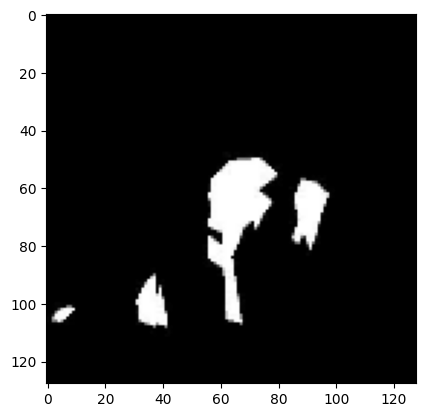

In [34]:
plt.imshow(y[0])

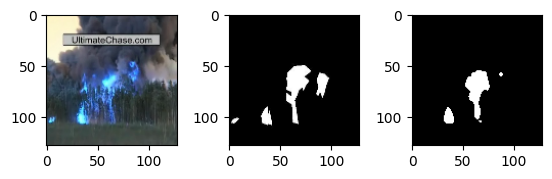

In [35]:
image_size = 128
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[0])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y[0])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[0]*255, (image_size, image_size)), cmap="gray")

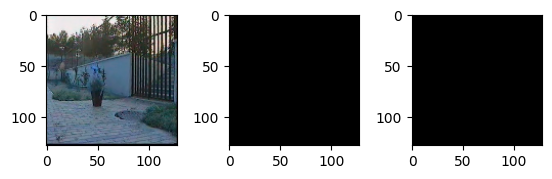

In [16]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[1])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y[1])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[1]*255, (image_size, image_size)), cmap="gray")

In [102]:
def precision_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_pred = np.sum(pred_mask)
    precision = np.mean(intersect/total_pixel_pred)
    return round(precision, 3)

def recall_score_(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_pixel_truth = np.sum(groundtruth_mask)
    recall = np.mean(intersect/total_pixel_truth)
    return round(recall, 3)

def accuracy(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    xor = np.sum(groundtruth_mask==pred_mask)
    acc = np.mean(xor/(union + xor - intersect))
    return round(acc, 3)

def dice_coef(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    total_sum = np.sum(pred_mask) + np.sum(groundtruth_mask)
    dice = np.mean(2*intersect/total_sum)
    return round(dice, 3) #round up to 3 decimal places

def iou(groundtruth_mask, pred_mask):
    intersect = np.sum(pred_mask*groundtruth_mask)
    union = np.sum(pred_mask) + np.sum(groundtruth_mask) - intersect
    iou = np.mean(intersect/union)
    return round(iou, 3)

def metrics_table(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(accuracy(mask, pred))
        metrics['Dice'].append(dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

def metrics_table_test(gt_masks, pred_masks):
    metrics = {'Precision':[],'Recall':[],'Accuracy':[],'Dice':[],'IoU':[]}
    for i, (mask, pred) in enumerate(zip(gt_masks, pred_masks)):
        mask = cv2.cvtColor(np.float32(mask), cv2.COLOR_BGR2GRAY)
        mask = np.expand_dims(mask, axis=-1)        
        metrics['Precision'].append(precision_score_(mask, pred))
        metrics['Recall'].append(recall_score_(mask, pred))
        metrics['Accuracy'].append(accuracy(mask, pred))
        metrics['Dice'].append(dice_coef(mask, pred))
        metrics['IoU'].append(iou(mask, pred))
    df = pd.DataFrame.from_dict(metrics)
    df.columns = ['Precision', 'Recall', 'Accuracy', 'Dice', 'IoU']
    return df

In [104]:
import pandas as pd
metrics_table_test(y, result)

,Precision,Recall,Accuracy,Dice,IoU
0,0.875,0.829,0.977,0.851,0.741
1,0.802,0.904,0.980,0.850,0.739
2,0.863,0.871,0.982,0.867,0.765
3,0.913,0.848,0.980,0.880,0.785
4,0.895,0.822,0.977,0.857,0.750
5,0.816,0.918,0.981,0.864,0.761
6,0.847,0.902,0.983,0.874,0.776
7,0.913,0.848,0.980,0.880,0.785
8,0.816,0.927,0.982,0.868,0.767
9,0.900,0.842,0.979,0.870,0.769


In [22]:
def getImage(image_path, image_size=128):
    image = cv2.imread(image_path, 1)
    image = cv2.resize(image, (image_size, image_size))
    image = image/255.0
    return image

In [19]:
test_path = "./Image/Not_Fire"
test_ids = next(os.walk(test_path))[2]

data = []

len(test_ids[:10])

for i in range(10):
    path = os.path.join("./Image/Not_Fire", test_ids[i])
    image = getImage(path)
    data.append(image)
    
data = np.array(data)
    
print(data)

StopIteration: 

In [24]:
result_test = model.predict(data)
result = result_test > 0.5

1/1 [==============================] - 1s 1s/step


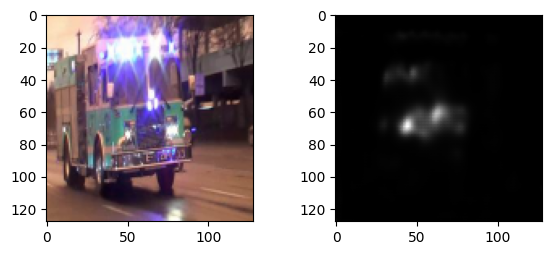

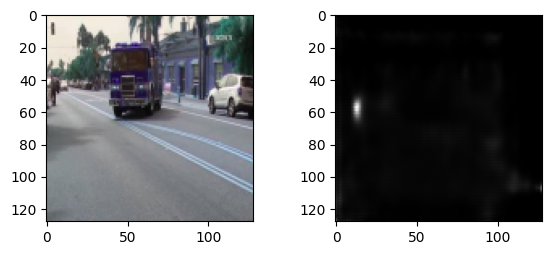

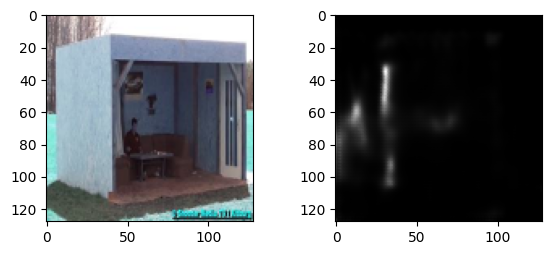

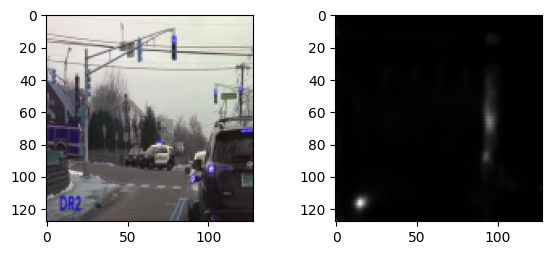

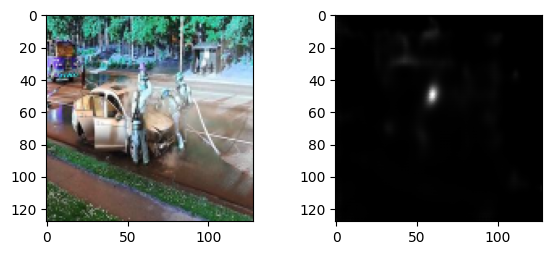

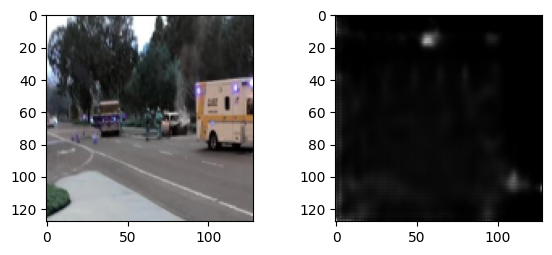

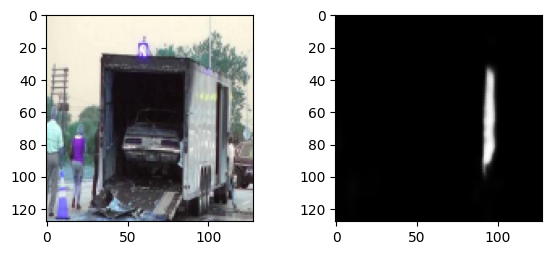

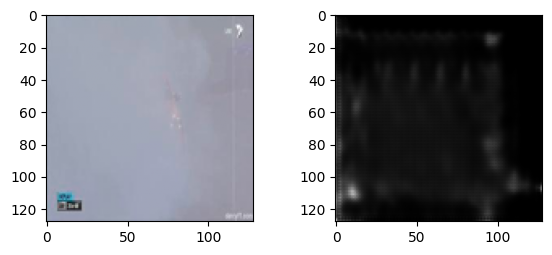

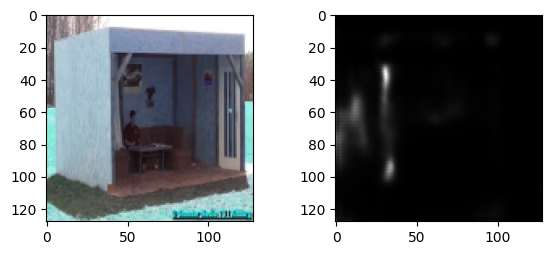

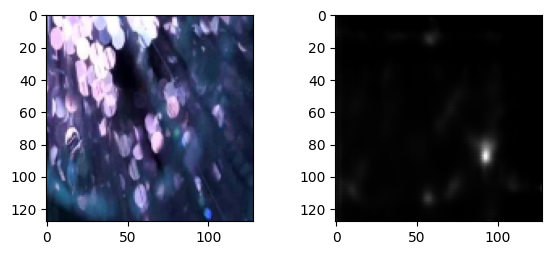

In [25]:
for i in range(len(result_test)):
    fig = plt.figure()
    fig.subplots_adjust(hspace=0.4, wspace=0.4)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(data[i])

    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.reshape(result_test[i]*255, (image_size, image_size)), cmap="gray")

In [70]:
class DataGenTesting(keras.utils.Sequence):
    def __init__(self, ids, ids_mask, path_image, batch_size=8, image_size=128):
        self.ids = ids
        self.ids_mask = ids_mask
        self.path_image = path_image
        self.batch_size = batch_size
        self.image_size = image_size
        self.on_epoch_end()
        
    def __load__(self, id_name, id_name_mask):
        ## Path
        image_path = os.path.join("./FireAnnotationDataset/Video02/Ori_Frames", id_name)
        mask_path = os.path.join("./FireAnnotationDataset/Video02/Video02_GT", id_name_mask)        
        # image_path = os.path.join(self.path, id_name, "images", id_name) + ".png"
        # mask_path = os.path.join(self.path, id_name, "masks/")
        # all_masks = os.listdir(mask_path)
        
        ## Reading Image
        image = cv2.imread(image_path, 1)
        image = cv2.resize(image, (self.image_size, self.image_size))
        
        mask = np.zeros((self.image_size, self.image_size, 1))
        
        ## Reading Masks
        # for name in all_masks:
        #     _mask_path = mask_path + name
        #     _mask_image = cv2.imread(_mask_path, -1)
        #     _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size)) #128x128
        #     _mask_image = np.expand_dims(_mask_image, axis=-1)
        
        _mask_image = cv2.imread(mask_path, -1)
        _mask_image = cv2.resize(_mask_image, (self.image_size, self.image_size))
#         _mask_image = np.expand_dims(_mask_image, axis=-1)
        mask = np.maximum(mask, _mask_image)
            
        ## Normalizing 
        image = image/255.0
        mask = mask/255.0
        
        return image, mask
    
    def __getitem__(self, index):
        if(index+1)*self.batch_size > len(self.ids):
            self.batch_size = len(self.ids) - index*self.batch_size
        
        files_batch = self.ids[index*self.batch_size : (index+1)*self.batch_size]
        files_batch_mask = self.ids_mask[index*self.batch_size : (index+1)*self.batch_size]
        image = []
        mask  = []
                
#         for files in files_batch:
        for i, (id_real, id_mask) in enumerate(zip(files_batch, files_batch_mask)):
            _img, _mask = self.__load__(id_real, id_mask)
            image.append(_img)
            mask.append(_mask)
            
        image = np.array(image)
        mask  = np.array(mask)
        
        return image, mask
    
    def on_epoch_end(self):
        pass
    
    def __len__(self):
        return int(np.ceil(len(self.ids)/float(self.batch_size)))

In [67]:
test_path = "./FireAnnotationDataset/Video02/Ori_Frames"
test_ids = next(os.walk(test_path))[2]
test_ids_mask = []

for i in test_ids:
    data = i.split("_")[1].split(".")[0]
    if (int(data) < 10):
        test_ids_mask.append("Video02_GT_00" + data + ".jpg")
    elif (int(data) < 100):
        test_ids_mask.append("Video02_GT_0" + data + ".jpg")
    else:
        test_ids_mask.append("Video02_GT_" + data + ".jpg")

test_size = len(test_ids)

In [71]:
test_gen = DataGenTesting(test_ids,test_ids_mask, test_path, image_size=128, batch_size=16)
x, y = test_gen.__getitem__(2)
result = model.predict(x)

result = result > 0.5

1/1 [==============================] - 0s 48ms/step


In [74]:
y.shape

(16, 128, 128, 3)

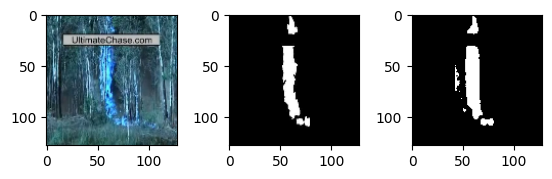

In [75]:
image_size = 128
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.4)

ax = fig.add_subplot(1, 3, 1)
ax.imshow(x[11])

ax = fig.add_subplot(1, 3, 2)
ax.imshow(y[11])

ax = fig.add_subplot(1, 3, 3)
ax.imshow(np.reshape(result[11]*255, (image_size, image_size)), cmap="gray")

In [37]:
result.shape

(16, 128, 128, 1)

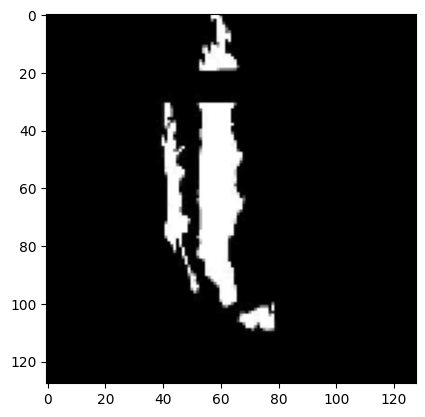

In [82]:
plt.imshow(y[0])

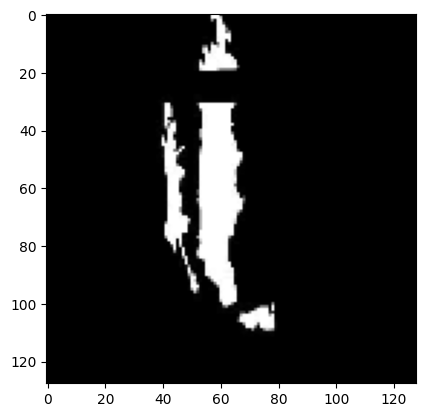

In [101]:
# y = np.squeeze(y, axis=2)
a = y[0]
a = cv2.cvtColor(np.float32(y[0]), cv2.COLOR_BGR2GRAY)
plt.imshow(a, cmap='gray')
a = np.expand_dims(a, axis=-1)

In [103]:
metrics_table_test(y, result)

,Precision,Recall,Accuracy,Dice,IoU
0,0.875,0.829,0.977,0.851,0.741
1,0.802,0.904,0.980,0.850,0.739
2,0.863,0.871,0.982,0.867,0.765
3,0.913,0.848,0.980,0.880,0.785
4,0.895,0.822,0.977,0.857,0.750
5,0.816,0.918,0.981,0.864,0.761
6,0.847,0.902,0.983,0.874,0.776
7,0.913,0.848,0.980,0.880,0.785
8,0.816,0.927,0.982,0.868,0.767
9,0.900,0.842,0.979,0.870,0.769
